In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')
# !cp "/content/drive/MyDrive/AI芒果辨識競賽/C1-P1_Train Dev.rar" "/content/"

In [1]:
# !mkdir "mango"
# !unrar x "C1-P1_Train Dev.rar" "mango"

In [1]:
DATA_DIR = 'data/mango'

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import shutil
import cv2
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b3, efficientnet_b0, efficientnet_b6
import torch
from torch.utils.data import Dataset
from torch.nn import ZeroPad2d
import matplotlib.pyplot as plt
import tensorflow as tf

PADDING_SIZE = 1536
IMG_SHAPE = (224, 224)
# BATCH_SIZE = 512
OUTPUT_CLASSES = 3
MEAN = [55.49694383, 60.2820865, 82.53554147]
STD = [65.72940478, 67.66902771, 87.42390442]
dtype = torch.float32

In [3]:
class History:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.running_loss = 0
        self.running_acc = 0
        
    def batch_train(self, batch_loss, batch_acc):
        self.running_loss += batch_loss
        self.running_acc += batch_acc
        
    def epoch_train(self, batch_num):
        self.train_loss.append(self.running_loss / batch_num)
        self.train_acc.append(self.running_acc / batch_num)
        self.running_loss = 0
        self.running_acc = 0
        
    def epoch_val(self, val_loss, val_acc):
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)


def calculate_accuracy(y_pred, y_true):
    # y_pred y_true要是2D array (每筆資料的label的onehot encoding)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
    correct = (y_pred == y_true).float().sum()
    accuracy = correct / len(y_true)
    return float(accuracy)

def validation(model, loader):
    num_correct = 0
    num_samples = 0
    loss = 0.0
    all_y_true = []
    all_y_pred = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y_true = y.to(device=device, dtype=dtype).argmax(axis=1)
            scores = model(x)      
            _, preds = scores.max(1)
            num = preds.size(0)
            loss += CE_loss(scores, y_true) * num
            
            all_y_true.append(y_true)
            all_y_pred.append(preds)

            num_correct += (preds == y_true).sum()
            num_samples += num
    acc = float(num_correct) / num_samples
    loss = float(loss / num_samples)
    return acc, loss, (all_y_true, all_y_pred)

In [4]:
def read_data(which="train", z_norm=True):
    data_dir = None
    y = None
    if which == "train":
        data_dir = os.path.join(DATA_DIR, "C1-P1_Train")
        label_csv = os.path.join(DATA_DIR, "train.csv")
    elif which == "test":
        data_dir = os.path.join(DATA_DIR, "C1-P1_Dev")
        label_csv = os.path.join(DATA_DIR, "dev.csv")
    else:
        print('input should be train or test')
        return

    X = []
    y = pd.get_dummies(pd.read_csv(label_csv, header=None)[1]).to_numpy()

    filenames = sorted(os.listdir(data_dir))  
    for filename in tqdm(filenames):
        fpath = os.path.join(data_dir, filename)
        img = cv2.imread(fpath)
        h,w,_ = img.shape
        top = int((PADDING_SIZE - h)/2)
        botoom = PADDING_SIZE - h - top
        left = int((PADDING_SIZE - w)/2)
        right = PADDING_SIZE - w - left

        # img = (img - MEAN) / STD
        img = img.astype(np.float32)
        img = cv2.copyMakeBorder(img, top, botoom, left, right, cv2.BORDER_CONSTANT)
        
        if z_norm:
            img[top:PADDING_SIZE-botoom, left:PADDING_SIZE-right] = \
              (img[top:PADDING_SIZE-botoom, left:PADDING_SIZE-right] - MEAN) / STD
        else:
            img /= 255.0

        img = cv2.resize(img, IMG_SHAPE)
        X.append(img)
        # display(Image.fromarray(img[:,:,::-1]))
        # break
  
    X = np.array(X)
    return X, y

In [5]:
%%time
# X_train, y_train = read_data(which="train", z_norm=False)
# X_test, y_test = read_data(which="test", z_norm=False)

npy_dir = "./data"
X_train = np.load(os.path.join(npy_dir, 'X_train.npy'))
y_train = np.load(os.path.join(npy_dir, 'y_train.npy'))
X_test = np.load(os.path.join(npy_dir, 'X_test.npy'))
y_test = np.load(os.path.join(npy_dir, 'y_test.npy'))

Wall time: 961 ms


In [6]:
# npy_dir = "./data/z_norm"
# npy_dir = "./data"
# np.save(os.path.join(npy_dir, 'X_train.npy'), X_train)
# np.save(os.path.join(npy_dir, 'y_train.npy'), y_train)
# np.save(os.path.join(npy_dir, 'X_test.npy'), X_test)
# np.save(os.path.join(npy_dir, 'y_test.npy'), y_test)

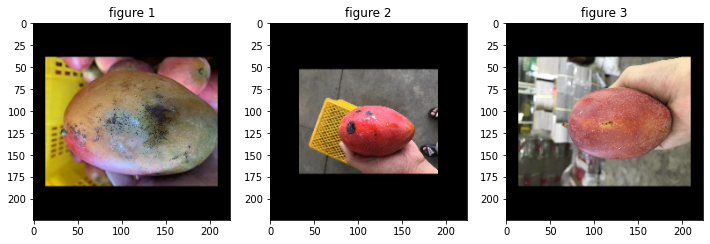

In [7]:
# from google.colab.patches import cv2_imshow
plt.figure(figsize=(12,8))
for i, img in enumerate(X_train[:3]):
#     print(f"第{i+1}張圖片:")
#     cv2_imshow(img*STD+MEAN)
#     img = img*STD+MEAN
#     img = img.astype(np.int32)
    ax = plt.subplot(1, 3, i+1)    
    plt.title(f"figure {i+1}")
    ax.imshow(img[:,:,::-1])

#     plt.imshow(img[:,:,::-1])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1028)

In [9]:
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_val.shape", X_val.shape)
print("y_val.shape", y_val.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_train.shape (5040, 224, 224, 3)
y_train.shape (5040, 3)
X_val.shape (560, 224, 224, 3)
y_val.shape (560, 3)
X_test.shape (800, 224, 224, 3)
y_test.shape (800, 3)


mean [55.49694383 60.2820865  82.53554147]

std [65.72940478 67.66902771 87.42390442]

In [10]:
# print("mean", X_train.mean(axis=(0,1,2)))
# print("std", np.sqrt(X_train.var(axis=(0,1,2))))

In [11]:
def pre_processing(X):
    X = X[:,:,:,::-1].transpose(0,3,1,2)
    X = torch.tensor(X.copy(), dtype=dtype)
    # X = torch.tensor(X, dtype=dtype)
    # f_norm = transforms.Normalize(
    #           mean=[55.49694383, 60.2820865, 82.53554147],
    #           std=[65.72940478, 67.66902771, 87.42390442])
    # X = f_norm(X)
    return X

class MangoDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        # self.X = pre_processing(X)
        self.X = X
        self.y = torch.tensor(y)
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image =  self.X[idx]
        image = image[:,:,::-1].transpose(2,0,1)
        image = torch.tensor(image.copy(), dtype=dtype)
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
data_aug = [
  transforms.RandomCrop((200, 200)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  transforms.RandomAffine(degrees=50, translate=(0.15, 0.15), scale=(0.8, 1)),
#   transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
]

transform = transforms.Compose([
  transforms.RandomOrder(data_aug),
])

In [13]:
import torch.nn as nn
import torch.nn.functional as F

def fc_bc_relu_dropout(in_size, out_size, p=0.5):
    return nn.Sequential(
        nn.Linear(in_size, out_size),
#         nn.BatchNorm1d(out_size), # 有 batchNorm 不知道為什麼train不起來
        nn.ReLU(),
        nn.Dropout(p=p),
    )

fc_model = nn.Sequential(
        nn.Dropout(p=0.5),
        fc_bc_relu_dropout(1000, 256, 0.5),
        fc_bc_relu_dropout(256, 128, 0.5),
        nn.Linear(128, OUTPUT_CLASSES),
#         nn.Softmax(-1), # nn.CrossEntropyLoss() 已經內建做了 Softmax了
    )

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        print(m)

print('init weights [nn.Linear] layers:')
fc_model.apply(weights_init)

model = nn.Sequential(
      efficientnet_b0(pretrained = False),
      fc_model,
    )

init weights [nn.Linear] layers:
Linear(in_features=1000, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=3, bias=True)


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import sampler
BATCH_SIZE = 64
train_dataset = MangoDataset(X_train, y_train, transform=transform)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# train_dataset = MangoDataset(X_train, y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
#                               shuffle=True, num_workers=0)

val_dataset = MangoDataset(X_val, y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_dataset = MangoDataset(X_test, y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [16]:
# freeze pretrain weight
for p in model[0].parameters():
  # p.requires_grad = False
  p.requires_grad = True

In [17]:
def count_parameters(model):
    trainable_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_p = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_p, non_trainable_p

print('# of parameters')
trainable_p, non_trainable_p = count_parameters(model)
print('trainable:     %15s' % format(trainable_p, ','))
print('non-trainable: %15s' % (format(non_trainable_p, ',')))

# of parameters
trainable:           5,578,087
non-trainable:               0


In [18]:
import torch.optim as optim

CE_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=8e-4, weight_decay=1e-3) #B0
# optimizer = optim.Adam(model.parameters(), lr=8e-4) #B0
# scheduler = optim.lr_scheduler.MultiStepLR(
#     optimizer, milestones=[4,10,20], gamma=0.75)
scheduler = None

In [19]:
EPOCH = 50

In [18]:

history = History()
for epoch in range(EPOCH):  # loop over the dataset multiple times    
    n_batches = len(train_dataloader)
    print(f'Epoch {epoch+1}/{EPOCH}')
    pbar = tf.keras.utils.Progbar(target=n_batches)
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device, dtype=dtype), data[1].to(device, dtype=dtype)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)

        loss = CE_loss(outputs, labels)
        loss.backward()
        
        optimizer.step()

        accuracy = calculate_accuracy(outputs, labels)
        loss = float(loss)
        
        pbar.update(i, values=[("train_loss", loss),
                    ("train_acc", accuracy)])
        
        history.batch_train(loss, accuracy)

    if scheduler and scheduler.__module__ == 'torch.optim.lr_scheduler':
        scheduler.step()
        
    val_acc, val_loss, _ = validation(model, val_dataloader)            
    pbar.update(n_batches, values=[('val_loss', val_loss), ('val_acc', val_acc)])
    
    history.epoch_train(n_batches)
    history.epoch_val(val_loss, val_acc)

print('Finished Training')

Epoch 1/50
79/79 [==============================] - 39s 449ms/step - train_loss: 1.4710 - train_acc: 0.3941 - val_loss: 1.3866 - val_acc: 0.3768
Epoch 2/50
79/79 [==============================] - 35s 442ms/step - train_loss: 1.0044 - train_acc: 0.4911 - val_loss: 1.0092 - val_acc: 0.5125
Epoch 3/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.9567 - train_acc: 0.5131 - val_loss: 0.9517 - val_acc: 0.5054
Epoch 4/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.9279 - train_acc: 0.5142 - val_loss: 0.9374 - val_acc: 0.5107
Epoch 5/50
79/79 [==============================] - 35s 442ms/step - train_loss: 0.9182 - train_acc: 0.5405 - val_loss: 0.9108 - val_acc: 0.5268
Epoch 6/50
79/79 [==============================] - 36s 445ms/step - train_loss: 0.9126 - train_acc: 0.5460 - val_loss: 0.9760 - val_acc: 0.5179
Epoch 7/50
79/79 [==============================] - 35s 442ms/step - train_loss: 0.9130 - train_acc: 0.5453 - val_loss: 0.9286 - v

In [19]:
test_acc, test_loss, y_true_pred = validation(model, test_dataloader)
print(f"Test Accuracy = %.4f" % test_acc)

Test Accuracy = 0.7125


In [20]:
val_acc, val_loss, _ = validation(model, val_dataloader)
print(f"Validation Accuracy = %.4f" % val_acc)

Validation Accuracy = 0.6750


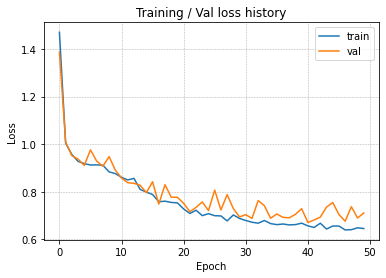

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.train_loss, label='train') 
plt.plot(history.val_loss, label='val') 
plt.title("Training / Val loss history")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(linestyle="--", linewidth=0.5)
plt.show()

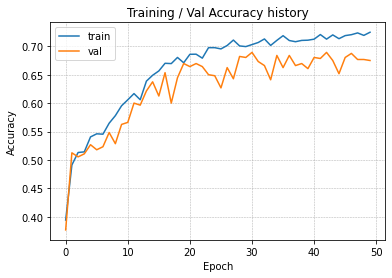

In [22]:
plt.plot(history.train_acc, label='train') 
plt.plot(history.val_acc, label='val') 
plt.title("Training / Val Accuracy history")
plt.xlabel("Epoch") # 這裡應該要是epoch
plt.ylabel("Accuracy")
plt.legend()
plt.grid(linestyle="--", linewidth=0.5)
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def make_confusion_matrix(y_true, y_score):
    cm = confusion_matrix(y_true, y_score)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C']) #
    disp.plot()
    return cm

In [24]:
y_true, y_pred = y_true_pred
y_true = torch.cat(([y_true[i] for i in range(len(y_true))]))
y_pred = torch.cat(([y_pred[i] for i in range(len(y_pred))]))
y_true = y_true.cpu()
y_pred = y_pred.cpu()

array([[216,  55,  17],
       [ 70, 170,  56],
       [ 13,  19, 184]], dtype=int64)

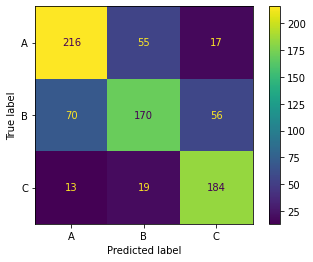

In [25]:
make_confusion_matrix(y_true, y_pred)

In [26]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred, digits=3, target_names=["A","B","C"]))

              precision    recall  f1-score   support

           A      0.722     0.750     0.736       288
           B      0.697     0.574     0.630       296
           C      0.716     0.852     0.778       216

    accuracy                          0.713       800
   macro avg      0.712     0.725     0.715       800
weighted avg      0.711     0.713     0.708       800



In [27]:
torch.save(model, 'model/eff_b0_no_pretrain.pt')

# 取多次平均

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCH = 50

In [21]:
def get_model():
    print('init weights [nn.Linear] layers:')
    fc_model.apply(weights_init)
    model = nn.Sequential(
          efficientnet_b0(pretrained = False),
          fc_model,
        )
    
    model = model.to(device)

    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    print(device)
    # freeze pretrain weight
    for p in model[0].parameters():      
        p.requires_grad = True
    
    return model

In [22]:
def training():
    history = History()
    model = get_model()
    CE_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=8e-4, weight_decay=1e-3)
    scheduler = None
    
    for epoch in range(EPOCH):  # loop over the dataset multiple times    
        n_batches = len(train_dataloader)
        print(f'Epoch {epoch+1}/{EPOCH}')
        pbar = tf.keras.utils.Progbar(target=n_batches)
        for i, data in enumerate(train_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device, dtype=dtype), data[1].to(device, dtype=dtype)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)

            loss = CE_loss(outputs, labels)
            loss.backward()

            optimizer.step()

            accuracy = calculate_accuracy(outputs, labels)
            loss = float(loss)

            pbar.update(i, values=[("train_loss", loss),
                        ("train_acc", accuracy)])

            history.batch_train(loss, accuracy)

        if scheduler and scheduler.__module__ == 'torch.optim.lr_scheduler':
            scheduler.step()

        val_acc, val_loss, _ = validation(model, val_dataloader)            
        pbar.update(n_batches, values=[('val_loss', val_loss), ('val_acc', val_acc)])

        history.epoch_train(n_batches)
        history.epoch_val(val_loss, val_acc)
        
    test_acc, test_loss, y_true_pred = validation(model, test_dataloader)
    print(f"Test Accuracy = %.4f" % test_acc)    
    return history, test_acc

In [23]:
history_list = []
test_acc_list = []

for i in range(10):
    his, test_acc = training()
    history_list.append(his)
    test_acc_list.append(test_acc)

init weights [nn.Linear] layers:
Linear(in_features=1000, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=3, bias=True)
cuda:0
Epoch 1/50
79/79 [==============================] - 38s 450ms/step - train_loss: 1.5034 - train_acc: 0.3605 - val_loss: 1.1910 - val_acc: 0.3982
Epoch 2/50
79/79 [==============================] - 35s 441ms/step - train_loss: 1.0928 - train_acc: 0.3724 - val_loss: 1.0961 - val_acc: 0.3357
Epoch 3/50
79/79 [==============================] - 35s 440ms/step - train_loss: 1.0900 - train_acc: 0.3658 - val_loss: 1.0869 - val_acc: 0.3946
Epoch 4/50
79/79 [==============================] - 35s 442ms/step - train_loss: 1.0893 - train_acc: 0.3677 - val_loss: 1.0863 - val_acc: 0.3946
Epoch 5/50
79/79 [==============================] - 35s 444ms/step - train_loss: 1.0790 - train_acc: 0.4028 - val_loss: 1.0911 - val_acc: 0.3357
Epoch 6/50
79/79 [==============================] - 35s 441ms/step - train_lo

79/79 [==============================] - 36s 448ms/step - train_loss: 1.0877 - train_acc: 0.3927 - val_loss: 1.0869 - val_acc: 0.3946
Epoch 5/50
79/79 [==============================] - 35s 443ms/step - train_loss: 1.0868 - train_acc: 0.3870 - val_loss: 1.1272 - val_acc: 0.4500
Epoch 6/50
79/79 [==============================] - 36s 444ms/step - train_loss: 1.0863 - train_acc: 0.3789 - val_loss: 1.0897 - val_acc: 0.3357
Epoch 7/50
79/79 [==============================] - 35s 442ms/step - train_loss: 1.0814 - train_acc: 0.4128 - val_loss: 1.0818 - val_acc: 0.3696
Epoch 8/50
79/79 [==============================] - 35s 442ms/step - train_loss: 1.0724 - train_acc: 0.4368 - val_loss: 1.0853 - val_acc: 0.4161
Epoch 9/50
79/79 [==============================] - 35s 444ms/step - train_loss: 1.0197 - train_acc: 0.4688 - val_loss: 0.9738 - val_acc: 0.4821
Epoch 10/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.9802 - train_acc: 0.5015 - val_loss: 0.9555 - val_acc: 0.

Epoch 9/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.8232 - train_acc: 0.6156 - val_loss: 0.9097 - val_acc: 0.5679
Epoch 10/50
79/79 [==============================] - 36s 444ms/step - train_loss: 0.8105 - train_acc: 0.6360 - val_loss: 0.9663 - val_acc: 0.5661
Epoch 11/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.8222 - train_acc: 0.6226 - val_loss: 0.8125 - val_acc: 0.6089
Epoch 12/50
79/79 [==============================] - 35s 441ms/step - train_loss: 0.7791 - train_acc: 0.6529 - val_loss: 0.8145 - val_acc: 0.6054
Epoch 13/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.7523 - train_acc: 0.6723 - val_loss: 0.7804 - val_acc: 0.6518
Epoch 14/50
79/79 [==============================] - 35s 441ms/step - train_loss: 0.7521 - train_acc: 0.6671 - val_loss: 0.8170 - val_acc: 0.6411
Epoch 15/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.7457 - train_acc: 0.6684 - val_loss: 0.80

79/79 [==============================] - 35s 443ms/step - train_loss: 0.7710 - train_acc: 0.6584 - val_loss: 0.7851 - val_acc: 0.6446
Epoch 14/50
79/79 [==============================] - 35s 442ms/step - train_loss: 0.7900 - train_acc: 0.6427 - val_loss: 0.8141 - val_acc: 0.6268
Epoch 15/50
79/79 [==============================] - 36s 446ms/step - train_loss: 0.7401 - train_acc: 0.6744 - val_loss: 0.7774 - val_acc: 0.6518
Epoch 16/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.7389 - train_acc: 0.6704 - val_loss: 0.7511 - val_acc: 0.6429
Epoch 17/50
79/79 [==============================] - 36s 447ms/step - train_loss: 0.7246 - train_acc: 0.6791 - val_loss: 0.8047 - val_acc: 0.6161
Epoch 18/50
79/79 [==============================] - 35s 444ms/step - train_loss: 0.7449 - train_acc: 0.6704 - val_loss: 0.7599 - val_acc: 0.6536
Epoch 19/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.7164 - train_acc: 0.6828 - val_loss: 0.8461 - val_ac

Epoch 18/50
79/79 [==============================] - 36s 444ms/step - train_loss: 0.7959 - train_acc: 0.6326 - val_loss: 0.8618 - val_acc: 0.5982
Epoch 19/50
79/79 [==============================] - 35s 440ms/step - train_loss: 0.7802 - train_acc: 0.6482 - val_loss: 0.8091 - val_acc: 0.6054
Epoch 20/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.7827 - train_acc: 0.6461 - val_loss: 0.8289 - val_acc: 0.5804
Epoch 21/50
79/79 [==============================] - 35s 440ms/step - train_loss: 0.7946 - train_acc: 0.6355 - val_loss: 0.8715 - val_acc: 0.6000
Epoch 22/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.7727 - train_acc: 0.6460 - val_loss: 0.9578 - val_acc: 0.5464
Epoch 23/50
79/79 [==============================] - 35s 441ms/step - train_loss: 0.7622 - train_acc: 0.6590 - val_loss: 0.8267 - val_acc: 0.6089
Epoch 24/50
79/79 [==============================] - 35s 440ms/step - train_loss: 0.7716 - train_acc: 0.6483 - val_loss: 1.0

79/79 [==============================] - 35s 442ms/step - train_loss: 0.7602 - train_acc: 0.6584 - val_loss: 0.8335 - val_acc: 0.6143
Epoch 23/50
79/79 [==============================] - 35s 441ms/step - train_loss: 0.7584 - train_acc: 0.6588 - val_loss: 0.8723 - val_acc: 0.5732
Epoch 24/50
79/79 [==============================] - 35s 440ms/step - train_loss: 0.7559 - train_acc: 0.6578 - val_loss: 0.8376 - val_acc: 0.6161
Epoch 25/50
79/79 [==============================] - 35s 442ms/step - train_loss: 0.7623 - train_acc: 0.6601 - val_loss: 0.8749 - val_acc: 0.5786
Epoch 26/50
79/79 [==============================] - 35s 441ms/step - train_loss: 0.7595 - train_acc: 0.6541 - val_loss: 0.8962 - val_acc: 0.5625
Epoch 27/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.7464 - train_acc: 0.6605 - val_loss: 0.9115 - val_acc: 0.5768
Epoch 28/50
79/79 [==============================] - 35s 442ms/step - train_loss: 0.7429 - train_acc: 0.6648 - val_loss: 0.8746 - val_ac

Epoch 27/50
79/79 [==============================] - 35s 442ms/step - train_loss: 1.0895 - train_acc: 0.3575 - val_loss: 1.0890 - val_acc: 0.3946
Epoch 28/50
79/79 [==============================] - 35s 441ms/step - train_loss: 1.0894 - train_acc: 0.3605 - val_loss: 1.0887 - val_acc: 0.3946
Epoch 29/50
79/79 [==============================] - 35s 443ms/step - train_loss: 1.0895 - train_acc: 0.3656 - val_loss: 1.0898 - val_acc: 0.3357
Epoch 30/50
79/79 [==============================] - 35s 443ms/step - train_loss: 1.0895 - train_acc: 0.3597 - val_loss: 1.0895 - val_acc: 0.3357
Epoch 31/50
79/79 [==============================] - 35s 442ms/step - train_loss: 1.0895 - train_acc: 0.3660 - val_loss: 1.0886 - val_acc: 0.3946
Epoch 32/50
79/79 [==============================] - 35s 442ms/step - train_loss: 1.0897 - train_acc: 0.3672 - val_loss: 1.0891 - val_acc: 0.3946
Epoch 33/50
79/79 [==============================] - 35s 443ms/step - train_loss: 1.0895 - train_acc: 0.3633 - val_loss: 1.0

79/79 [==============================] - 35s 444ms/step - train_loss: 0.7153 - train_acc: 0.6843 - val_loss: 0.8309 - val_acc: 0.6304
Epoch 32/50
79/79 [==============================] - 35s 442ms/step - train_loss: 0.7235 - train_acc: 0.6822 - val_loss: 0.7698 - val_acc: 0.6393
Epoch 33/50
79/79 [==============================] - 35s 443ms/step - train_loss: 0.7272 - train_acc: 0.6814 - val_loss: 0.7925 - val_acc: 0.6286
Epoch 34/50
79/79 [==============================] - 35s 442ms/step - train_loss: 0.7153 - train_acc: 0.6886 - val_loss: 0.7950 - val_acc: 0.6411
Epoch 35/50
79/79 [==============================] - 35s 436ms/step - train_loss: 0.7132 - train_acc: 0.6892 - val_loss: 0.7706 - val_acc: 0.6518
Epoch 36/50
79/79 [==============================] - 35s 436ms/step - train_loss: 0.7065 - train_acc: 0.6907 - val_loss: 0.7624 - val_acc: 0.6589
Epoch 37/50
79/79 [==============================] - 35s 435ms/step - train_loss: 0.7001 - train_acc: 0.6886 - val_loss: 0.7526 - val_ac

Epoch 36/50
79/79 [==============================] - 35s 435ms/step - train_loss: 0.7313 - train_acc: 0.6684 - val_loss: 0.8060 - val_acc: 0.6143
Epoch 37/50
79/79 [==============================] - 35s 438ms/step - train_loss: 0.7430 - train_acc: 0.6681 - val_loss: 0.8142 - val_acc: 0.6143
Epoch 38/50
79/79 [==============================] - 35s 434ms/step - train_loss: 0.7258 - train_acc: 0.6793 - val_loss: 0.8192 - val_acc: 0.6000
Epoch 39/50
79/79 [==============================] - 35s 436ms/step - train_loss: 0.7248 - train_acc: 0.6714 - val_loss: 0.8114 - val_acc: 0.6125
Epoch 40/50
79/79 [==============================] - 35s 435ms/step - train_loss: 0.7254 - train_acc: 0.6721 - val_loss: 0.8038 - val_acc: 0.6089
Epoch 41/50
79/79 [==============================] - 35s 436ms/step - train_loss: 0.7282 - train_acc: 0.6773 - val_loss: 0.8440 - val_acc: 0.6125
Epoch 42/50
79/79 [==============================] - 35s 435ms/step - train_loss: 0.7318 - train_acc: 0.6712 - val_loss: 0.7

79/79 [==============================] - 35s 436ms/step - train_loss: 1.0894 - train_acc: 0.3535 - val_loss: 1.0887 - val_acc: 0.3946
Epoch 41/50
79/79 [==============================] - 35s 435ms/step - train_loss: 1.0895 - train_acc: 0.3672 - val_loss: 1.0890 - val_acc: 0.3946
Epoch 42/50
79/79 [==============================] - 35s 434ms/step - train_loss: 1.0896 - train_acc: 0.3586 - val_loss: 1.0886 - val_acc: 0.3946
Epoch 43/50
79/79 [==============================] - 35s 435ms/step - train_loss: 1.0896 - train_acc: 0.3608 - val_loss: 1.0884 - val_acc: 0.3946
Epoch 44/50
79/79 [==============================] - 35s 438ms/step - train_loss: 1.0898 - train_acc: 0.3569 - val_loss: 1.0887 - val_acc: 0.3946
Epoch 45/50
79/79 [==============================] - 35s 436ms/step - train_loss: 1.0896 - train_acc: 0.3622 - val_loss: 1.0892 - val_acc: 0.3946
Epoch 46/50
79/79 [==============================] - 35s 434ms/step - train_loss: 1.0898 - train_acc: 0.3627 - val_loss: 1.0881 - val_ac

In [24]:
test_acc_list

[0.37, 0.705, 0.7125, 0.69625, 0.59125, 0.5725, 0.36, 0.67, 0.57, 0.37]

In [28]:
print("%.4f" % np.mean(test_acc_list))

0.5618


In [29]:
print("%.4f" % (np.var(test_acc_list)**0.5))

0.1372
